In [1]:
import pickle
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from tqdm import tqdm
import random
import torch.optim as optim
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from scipy.stats import pearsonr
from scipy.stats import spearmanr
from scipy.stats import kendalltau
import datetime
import random
import string
import plotly.express as px
import MDAnalysis as mda
import scipy.io

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [3]:
with open('final_coordinates.pkl','rb') as file:
    inp = pickle.load(file)
with open('s_list.pkl','rb') as file:
    s = pickle.load(file)

In [4]:
inp.shape

(40286, 3072, 3)

In [5]:
x = inp[40000]
x.shape

(3072, 3)

In [25]:
data = {'x': x[:,0], 'y': x[:,1], 'z': x[:,2]}
df = pd.DataFrame(data)

# Create an interactive 3D scatter plot
fig = px.scatter_3d(df, x='x', y='y', z='z', title='Interactive 3D Scatter Plot')
fig.update_traces(marker=dict(size=2, color='blue', opacity=0.7))
# Show the plot
fig.show()
print(s[40000])

[1.00223206]


Text(0, 0.5, 'Frequency')

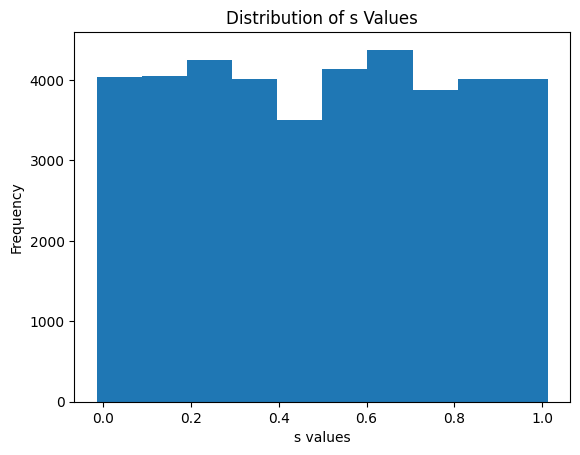

In [4]:
plt.hist(s)
plt.title("Distribution of s Values")
plt.xlabel('s values')
plt.ylabel('Frequency')

In [6]:
inp_train, inp_val, s_train, s_val = train_test_split(inp, s, test_size=0.2, random_state=69)
inp_train, inp_test, s_train, s_test = train_test_split(inp_train, s_train, test_size=0.2, random_state=69)

In [7]:
inp_train.shape, inp_val.shape, inp_test.shape

((25782, 3072, 3), (8058, 3072, 3), (6446, 3072, 3))

In [8]:
s_train.shape, s_val.shape, s_test.shape

((25782, 1), (8058, 1), (6446, 1))

In [9]:
learning_rate = 0.0006
batch_size = 32

In [10]:
def pairwise_distances(x):
    square = torch.sum(x ** 2, dim=1, keepdim=True)
    distances = square + torch.transpose(square, 0, 1) - 2 * torch.matmul(x, torch.transpose(x, 0, 1))
    distances = torch.sqrt(distances)
    return distances

In [11]:
def getDataLoader(x,y):
    tensor_inp = torch.Tensor(x)
    tensor_z = torch.Tensor(y)
    dataset = TensorDataset(tensor_inp,tensor_z)
    return DataLoader(dataset, batch_size)

In [12]:
def train(
    model,
    dataset,
    optimizer,
    loss,
    length_of_set,
    is_dev=False
):
    total_loss = 0
    y_pred, y_actual = [], []
    model.train()
    for x,y in tqdm(dataset):
        
        if not is_dev: optimizer.zero_grad()

        x = x.to(device)
        y = y.to(device)
        
        num_atoms = x.shape[1]
        batch_size = x.shape[0]
        adjacency_matrix = torch.zeros(batch_size, num_atoms, num_atoms).to(device)
        
        for i in range(batch_size):
            # Calculate pairwise distances between atoms
            distances = pairwise_distances(x[i])
            
            # Apply threshold to set adjacency values
            adjacency_matrix[i] = (distances < 7).float()
        
        pred = model(x,adjacency_matrix)
        curr_loss = loss(pred, y)
#         loss_batch = 0
#         loss_batch += curr_loss.item()
#         loss_batch = loss_batch*len(y)
        total_loss += curr_loss.item()*len(y)/(length_of_set)

        if not is_dev:
            curr_loss.backward()
            optimizer.step()

#         y_pred += pred
#         y_actual += y
        
        y_pred += pred.flatten().tolist()
        y_actual += y.flatten().tolist()
        
    return total_loss

In [13]:
train_dataloader = getDataLoader(inp_train, s_train)
val_dataloader = getDataLoader(inp_val, s_val)
test_dataloader = getDataLoader(inp_test, s_test)

In [34]:
class GNN(nn.Module):
    def __init__(self):
        super(GNN, self).__init__()
        self.fc1 = nn.Linear(3, 100)
        self.fc2 = nn.Linear(100, 1)
        self.fc3 = nn.Linear(3072,1)

    def forward(self, x, adjacency_matrix):
        x = self.fc1(x)
        x = torch.relu(x)
#         for i in range(2):
        x = torch.matmul(adjacency_matrix, x) + # Perform message passing using the adjacency matrix
#         x = torch.sigmoid(x)
        x = self.fc2(x)
        x = torch.relu(x)
        x = x.view(x.size(0), -1)
        x = self.fc3(x)
        x = torch.sigmoid(x)
#         x = torch.mean(x, dim=0)
        return x

In [35]:
model = GNN().to(device)
print(model)
loss = nn.MSELoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.LambdaLR(optimizer, lambda epoch: 0.5 ** epoch)

GNN(
  (fc1): Linear(in_features=3, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=1, bias=True)
  (fc3): Linear(in_features=3072, out_features=1, bias=True)
)


In [36]:
file_name = '1shell_7.txt'

In [37]:
file = open(file_name, "a")
threshold = 1e-4
# file.write('\n')
num_epochs = 10
losses = []
file.write(f"Batch Size: {batch_size}, Learning Rate: {learning_rate} \n")
for epoch in range(num_epochs):
    train_loss = train(model, train_dataloader, optimizer, loss, inp_train.shape[0])
    val_loss = train(model, val_dataloader, optimizer, loss, inp_val.shape[0], True)
    print(f'Epoch: {epoch+1}/{num_epochs} train loss: {train_loss} val_loss: {val_loss}')
    file.write(f'Epoch: {epoch+1}/{num_epochs} train loss: {train_loss} val_loss: {val_loss} \n')
#     if losses:
#         previous_loss = losses[-1]
#         current_loss = val_loss
#         if((previous_loss - current_loss) < threshold):
#             print(f"Validation loss reached the threshold ({threshold}). Stopping training.")
#             file.write((f"Validation loss reached the threshold ({threshold}). Stopping training."))
#             break
    losses.append(val_loss)
    scheduler.step()
#     if not losses: 
#         continue
#     else:
#         previous_loss = losses[-1]
#         current_loss = val_loss
#         if((previous_loss - current_loss) < threshold):
#             print(f"Validation loss reached the threshold ({threshold}). Stopping training.")
#             file.write((f"Validation loss reached the threshold ({threshold}). Stopping training."))
#             break
file.close()

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 576/576 [01:50<00:00,  5.20it/s]


Epoch: 1/10 train loss: 0.006004731024083518 val_loss: 0.0018027306235047806


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 576/576 [01:53<00:00,  5.06it/s]


Epoch: 2/10 train loss: 0.001563457518474551 val_loss: 0.0012375430601011457


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 576/576 [01:55<00:00,  5.00it/s]


Epoch: 3/10 train loss: 0.0010475866260641557 val_loss: 0.0008496251922863542


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 576/576 [01:57<00:00,  4.90it/s]


Epoch: 4/10 train loss: 0.0008358055487760688 val_loss: 0.000807647176287314


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 576/576 [01:56<00:00,  4.94it/s]


Epoch: 5/10 train loss: 0.0007410636507670476 val_loss: 0.0007026249716621034


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 576/576 [01:57<00:00,  4.91it/s]


Epoch: 6/10 train loss: 0.0006918745555197734 val_loss: 0.0006765992635223395


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 576/576 [02:17<00:00,  4.18it/s]


Epoch: 7/10 train loss: 0.0006660720489919154 val_loss: 0.0006656640886259363


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 576/576 [02:38<00:00,  3.64it/s]


Epoch: 8/10 train loss: 0.0006536780033561093 val_loss: 0.0006579122677573613


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 576/576 [02:17<00:00,  4.19it/s]


Epoch: 9/10 train loss: 0.0006475487064422308 val_loss: 0.0006555374075372021


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 576/576 [02:07<00:00,  4.50it/s]

Epoch: 10/10 train loss: 0.0006444172089219272 val_loss: 0.0006540139673603833


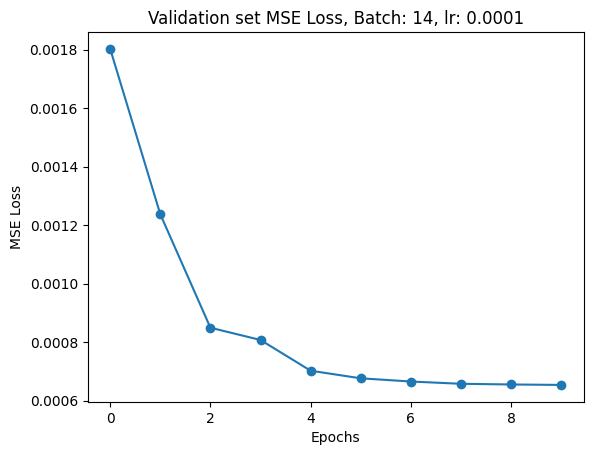

In [38]:
plt.plot(losses, marker='o')
plt.title(f"Validation set MSE Loss, Batch: {batch_size}, lr: {learning_rate}")
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.savefig('1shell_7_real_loss.png', bbox_inches='tight')

In [39]:
test_loss = train(model, test_dataloader, optimizer, loss, inp_test.shape[0], True)
print('test loss:',test_loss)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 461/461 [01:24<00:00,  5.45it/s]

test loss: 0.0006714857728558608


In [41]:
for x, y in test_dataloader:
    num_atoms = x.shape[1]
    batch_size = x.shape[0]
    adjacency_matrix_test = torch.zeros(batch_size, num_atoms, num_atoms).to(device)
        
    for i in tqdm(range(batch_size)):
        # Calculate pairwise distances between atoms
        distances = pairwise_distances(x[i])
            
            # Apply threshold to set adjacency values
        adjacency_matrix_test[i] = (distances < 7).float()
    outputs = model(x.to(device),adjacency_matrix_test)
    for i in range(32):
        print(outputs[i],y[i])
    break

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 16.45it/s]

tensor([0.0675], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.0793])
tensor([0.5132], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.5131])
tensor([0.0666], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.0752])
tensor([0.4887], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.4780])
tensor([0.7274], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.7520])
tensor([0.4885], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.4103])
tensor([0.2449], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.2702])
tensor([0.3650], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.3654])
tensor([0.0897], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.1240])
tensor([0.0778], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.0641])
tensor([0.9079], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.8850])
tensor([0.3198], device='cuda:0', grad_fn=<SelectBackward0>) tensor([0.3211])
tensor([0.8083], device='cuda:0', grad_fn=<SelectBackward0>) ten

IndexError: index 14 is out of bounds for dimension 0 with size 14

In [42]:
out = []
for x, y in tqdm(test_dataloader):
    num_atoms = x.shape[1]
    batch_size = x.shape[0]
    adjacency_matrix_test = torch.zeros(batch_size, num_atoms, num_atoms).to(device)
        
    for i in (range(batch_size)):
        # Calculate pairwise distances between atoms
        distances = pairwise_distances(x[i])
            
            # Apply threshold to set adjacency values
        adjacency_matrix_test[i] = (distances < 7).float()
    outputs = model(x.to(device),adjacency_matrix_test)
    outputs = outputs.cpu().detach()
    outputs = outputs.numpy()
    out.extend(outputs)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 461/461 [08:56<00:00,  1.16s/it]


Spearman rank correlation coefficient: 0.9959900461337745
ps-value: 0.0
Kendall rank correlation coefficient: 0.9427259512517552
pk-value: 0.0
R2_sqaure: 0.9923427383179261


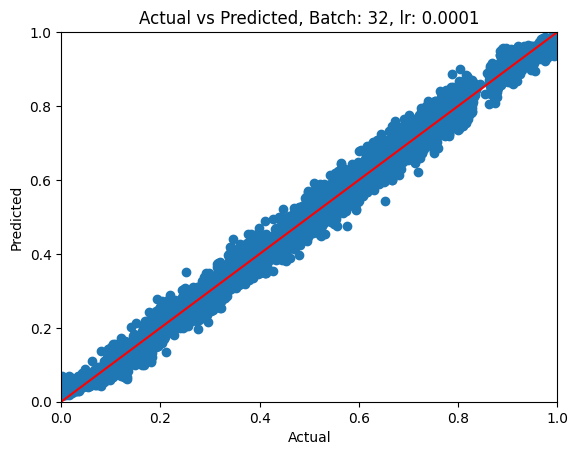

In [43]:
plt.scatter(s_test,out)
plt.xlim([0,1])
plt.ylim([0,1])
plt.title(f"Actual vs Predicted, Batch: 32, lr: {learning_rate}")
plt.xlabel('Actual')
plt.ylabel('Predicted')

p1 = max(max(out), max(s_test))
p2 = min(min(out), min(s_test))
plt.plot([p1, p2], [p1, p2], 'r-')
# plt.ylim((0.2,0.8))
R_sqaure = r2_score(s_test,out)

s_corr, ps_value = spearmanr(s_test, out)

print("Spearman rank correlation coefficient:", s_corr)
print("ps-value:", ps_value)

k_corr, pk_value = kendalltau(s_test, out)

print("Kendall rank correlation coefficient:", k_corr)
print("pk-value:", pk_value)

print("R2_sqaure:",R_sqaure)
file = open(file_name,'a')
file.write('\n')
file.write(f"test_loss: {test_loss}\n")
file.write(f"R^2: {R_sqaure}\n")
file.write(f"Spearman rank correlation coefficient: {s_corr}\n")
file.write(f"Kendall rank correlation coefficient: {k_corr}\n")
file.close()
plt.savefig('1shell_7_real_result.png',bbox_inches='tight')